In [26]:
import sklearn.metrics as metrics
#from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings('ignore')


In [2]:
def mean_absolute_percentage_error(y_test,y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    errors = abs(y_test - y_pred)
    mape = 100 * np.mean(errors / y_test)
    print('mape---{}'.format(mape))
    mape1= np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    return mape


In [3]:
def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    mse=metrics.mean_squared_error(y,ypred)
    r2=metrics.r2_score(y,ypred)

    return MAE,RMSE,mse,r2

In [4]:
#price_usd_df=pd.read_excel("/content/drive/MyDrive/Dissertation/My Dissertation/Data/After preprocessing/Bitcoin price and forex in USD_next day_after smoothing.xlsx")
price_usd_df=pd.read_excel("/content/drive/MyDrive/Dissertation/My Dissertation/Data/Pre-processed results/Removed missing values.xlsx")

print(price_usd_df.dtypes)
price_usd_df
df=price_usd_df

Date      datetime64[ns]
XBTUSD           float64
AUDUSD           float64
CADUSD           float64
CNYUSD           float64
EURUSD           float64
GBPUSD           float64
JPYUSD           float64
NZDUSD           float64
SGDUSD           float64
dtype: object


In [5]:
df=df.drop(['Date'],axis=1)
df.columns

Index(['XBTUSD', 'AUDUSD', 'CADUSD', 'CNYUSD', 'EURUSD', 'GBPUSD', 'JPYUSD',
       'NZDUSD', 'SGDUSD'],
      dtype='object')

In [6]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    print('input shifted:{}'.format(i))
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    print('output shifted:{}'.format(i))
	# put it all together
  agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg.values

In [78]:
lag = 7 #adding 3 days lags creating number of observations 
n_features = 9 #Features in the dataset.
n_obs = lag*n_features
n_obs

63

In [79]:
values=df.values
values.shape

(1836, 9)

In [80]:
series_data = series_to_supervised(values,lag)
series_data_Df=pd.DataFrame(series_data)
series_data_Df.head(10)

input shifted:7
input shifted:6
input shifted:5
input shifted:4
input shifted:3
input shifted:2
input shifted:1
output shifted:0


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1024.38,0.7219,0.7448,0.14385,1.0405,1.2237,0.008493,0.6918,0.6895,1091.66,...,0.6963,789.11,0.7441,0.7589,0.14471,1.0582,1.2213,0.008665,0.7055,0.7008
1,1091.66,0.7283,0.7519,0.14504,1.0489,1.2323,0.008529,0.6970,0.6948,971.26,...,0.7008,827.63,0.7484,0.7608,0.14515,1.0613,1.2162,0.008717,0.7095,0.7006
2,971.26,0.7338,0.7562,0.14547,1.0607,1.2419,0.008669,0.7026,0.7001,898.16,...,0.7006,830.70,0.7502,0.7625,0.14506,1.0643,1.2182,0.008733,0.7131,0.6998
3,898.16,0.7301,0.7555,0.14424,1.0532,1.2287,0.008547,0.6960,0.6950,917.41,...,0.6998,822.20,0.7502,0.7625,0.14506,1.0643,1.2182,0.008733,0.7131,0.6998
4,917.41,0.7301,0.7555,0.14424,1.0532,1.2287,0.008547,0.6960,0.6950,897.51,...,0.6998,833.10,0.7477,0.7589,0.14506,1.0601,1.2047,0.008757,0.7103,0.6991
5,897.51,0.7354,0.7567,0.14416,1.0574,1.2163,0.008617,0.7016,0.6962,909.81,...,0.6991,898.92,0.7567,0.7668,0.14613,1.0713,1.2414,0.008880,0.7215,0.7065
6,909.81,0.7368,0.7557,0.14435,1.0554,1.2177,0.008637,0.6990,0.6963,789.11,...,0.7065,875.76,0.7505,0.7535,0.14546,1.0630,1.2261,0.008724,0.7123,0.6995
7,789.11,0.7441,0.7589,0.14471,1.0582,1.2213,0.008665,0.7055,0.7008,827.63,...,0.6995,907.31,0.7561,0.7509,0.14530,1.0664,1.2342,0.008706,0.7190,0.7014
8,827.63,0.7484,0.7608,0.14515,1.0613,1.2162,0.008717,0.7095,0.7006,830.70,...,0.7014,898.86,0.7555,0.7508,0.14551,1.0703,1.2375,0.008724,0.7170,0.7015
9,830.70,0.7502,0.7625,0.14506,1.0643,1.2182,0.008733,0.7131,0.6998,822.20,...,0.7015,920.85,0.7555,0.7508,0.14551,1.0703,1.2375,0.008724,0.7170,0.7015


In [81]:
series_data.shape

(1829, 72)

In [82]:
y=series_data[:,-n_features].reshape(-1,1)
x=series_data[:,:-n_features]

In [83]:
split_point=int(0.8*len(series_data))
split_point

1463

In [84]:
train_X,test_X,train_Y,test_Y=x[:int(0.8*(len(x)))],x[int(0.8*(len(x))):],y[:int(0.8*(len(y)))],y[int(0.8*(len(y))):]

In [85]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(train_X)
print(train_Y)

(1463, 63)
(1463, 1)
(366, 63)
(366, 1)
[[1.024380e+03 7.219000e-01 7.448000e-01 ... 8.637000e-03 6.990000e-01
  6.963000e-01]
 [1.091660e+03 7.283000e-01 7.519000e-01 ... 8.665000e-03 7.055000e-01
  7.008000e-01]
 [9.712600e+02 7.338000e-01 7.562000e-01 ... 8.717000e-03 7.095000e-01
  7.006000e-01]
 ...
 [3.385430e+04 7.488000e-01 8.035000e-01 ... 9.084000e-03 6.999000e-01
  7.368000e-01]
 [3.284959e+04 7.476000e-01 8.030000e-01 ... 9.084000e-03 6.999000e-01
  7.368000e-01]
 [3.250834e+04 7.447000e-01 7.990000e-01 ... 9.136000e-03 6.944000e-01
  7.334000e-01]]
[[  789.11]
 [  827.63]
 [  830.7 ]
 ...
 [31652.45]
 [30776.39]
 [29865.53]]


In [86]:
regressor=xgboost.XGBRegressor()
xgmodel=regressor.fit(train_X,train_Y)


[14:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [87]:
base_pred=xgmodel.predict(test_X)
base_pred=base_pred.reshape(-1,1)

In [88]:
test_Y.reshape(-1,1)

array([[31818.67],
       [32247.75],
       [32500.7 ],
       [33939.65],
       [34483.2 ],
       [37751.68],
       [38044.5 ],
       [39985.95],
       [39722.08],
       [40689.27],
       [41540.22],
       [41268.06],
       [38856.63],
       [38072.95],
       [39754.38],
       [40899.36],
       [42719.51],
       [43975.95],
       [43867.4 ],
       [45464.51],
       [45642.9 ],
       [46345.49],
       [44480.11],
       [47609.88],
       [46666.78],
       [46718.33],
       [46078.11],
       [44992.1 ],
       [44546.67],
       [46587.99],
       [48668.03],
       [49011.76],
       [48414.22],
       [49515.08],
       [48345.65],
       [48712.63],
       [47036.43],
       [48921.81],
       [48755.08],
       [48925.24],
       [48648.9 ],
       [47008.53],
       [48272.51],
       [49562.1 ],
       [50152.52],
       [50182.7 ],
       [51668.21],
       [51934.74],
       [46819.01],
       [46060.72],
       [46256.1 ],
       [45077.81],
       [4531

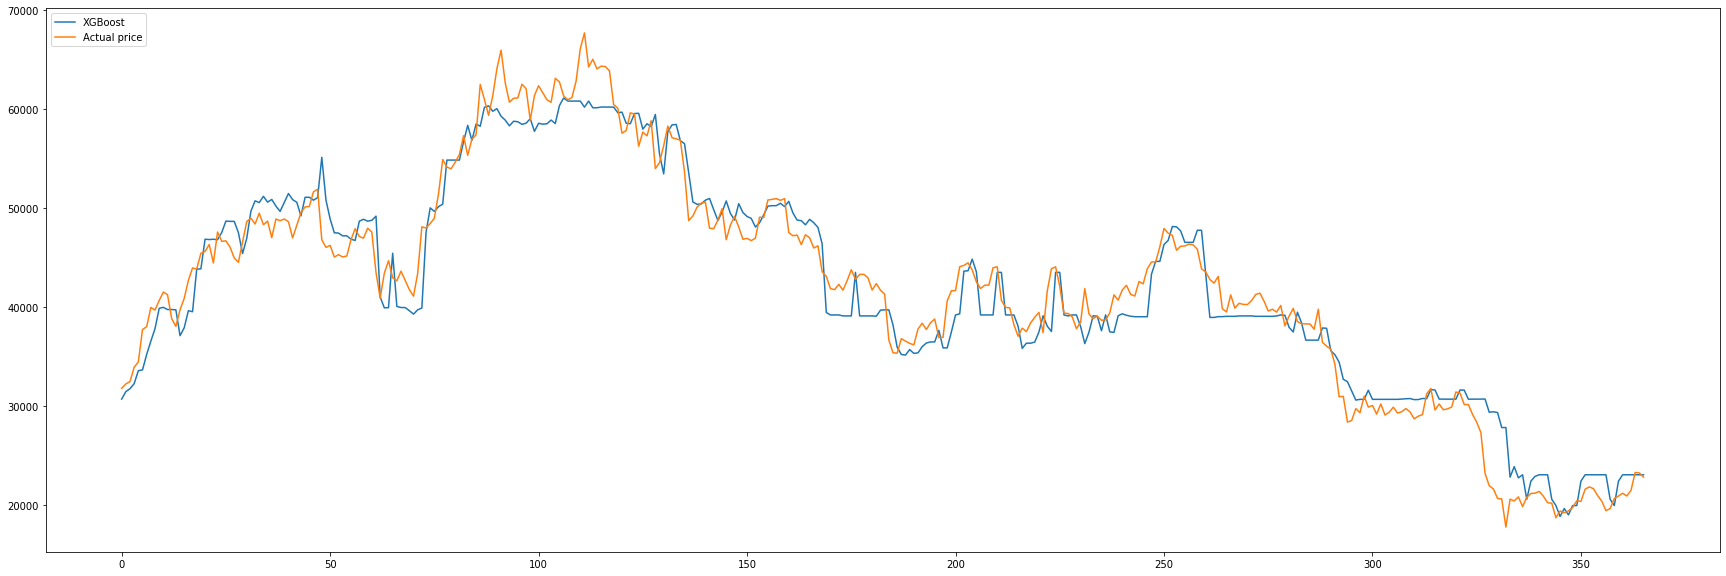

In [89]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(base_pred,label='XGBoost')
plt.plot(test_Y,label='Actual price')
plt.legend(loc="upper left")
plt.show()

In [90]:
mape = mean_absolute_percentage_error(test_Y,base_pred)
mae,rmse,mse,r2=calculate_metrics(test_Y,base_pred)
print('Results of XG boost model wihtout tuning')
print('MAPE  :{:0.4f}'.format(mape))
print('MAE  :{:0.4f}'.format(mae))
print('RMSE :{:0.4f} '.format(rmse))
print('MSE :{:0.4f} '.format(mse))
print('r2   :{:0.4f}'.format(r2))

mape---5.226555493488201
Results of XG boost model wihtout tuning
MAPE  :5.2266
MAE  :2005.5028
RMSE :2590.4579 
MSE :6710472.3245 
r2   :0.9481


# ***Hyperparameter tuning***

In [91]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [92]:
n_estimators = [100, 500, 900, 1100, 1500,1900,2100,2500]
max_depth = [2, 3, 5, 10, 15, 20, 25,30]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20, 0.25, 0.30, 0.35, 0.40]
min_child_weight=[1,2,3,4,5,6,7,8]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [93]:
from sklearn.model_selection import RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [94]:
random_cv.fit(train_X,train_Y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[15:33:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3, 0.35,
                                                          0.4],
                                        'max_depth': [2, 3, 5, 10, 15, 20, 25,
                                                      30],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500, 1900, 2100,
                                                         2500]},
                   random_state=42, return_train_score=

In [95]:
random_cv.best_estimator_

XGBRegressor(booster='gblinear', learning_rate=0.4, max_depth=5,
             min_child_weight=3, n_estimators=2500)

In [96]:
regressor=xgboost.XGBRegressor(booster='gblinear', learning_rate=0.4, max_depth=5,
             min_child_weight=3, n_estimators=2500)
xgmodel_htune=regressor.fit(train_X,train_Y)

[15:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [97]:
tuned_pred=xgmodel_htune.predict(test_X)
tuned_pred=tuned_pred.reshape(-1,1)

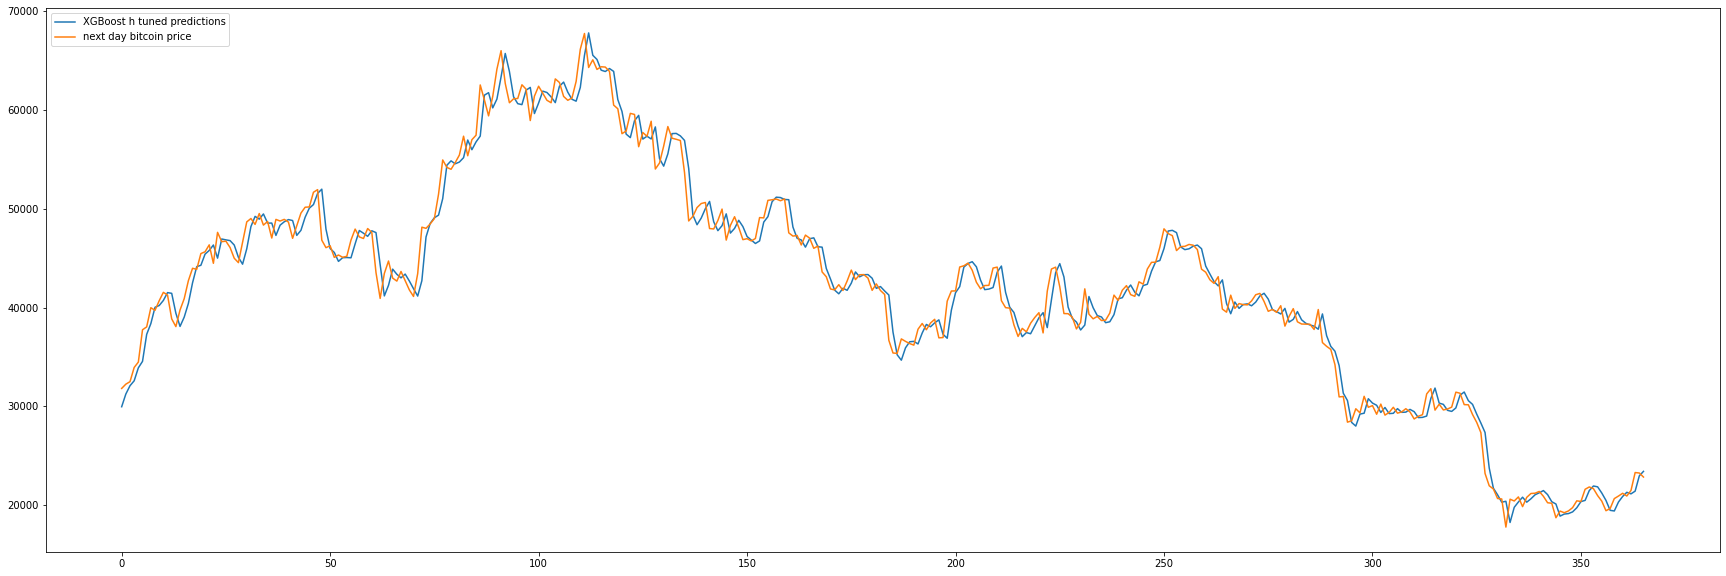

In [98]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(tuned_pred,label='XGBoost h tuned predictions')
plt.plot(test_Y,label='next day bitcoin price')
plt.legend(loc="upper left")
plt.show()

In [99]:
mape = mean_absolute_percentage_error(test_Y,tuned_pred)
mae,rmse,mse,r2=calculate_metrics(test_Y,tuned_pred)
print('Results of XG boost model after tuning')
print('MAPE  :{:0.4f}'.format(mape))
print('MAE  :{:0.4f}'.format(mae))
print('RMSE :{:0.4f} '.format(rmse))
print('MSE :{:0.4f} '.format(mse))
print('r2   :{:0.4f}'.format(r2))

mape---2.7165030623228397
Results of XG boost model after tuning
MAPE  :2.7165
MAE  :1111.3384
RMSE :1534.9107 
MSE :2355950.7355 
r2   :0.9818


In [102]:
test_Y.mean(), test_Y.max(),test_Y.min()

(42215.61806010929, 67734.04, 17785.09)

In [103]:
rmse_scaled=rmse/(test_Y.max()-test_Y.min())
rmse_scaled

0.030729588118083302